In [1]:
import numpy as np
from astropy.io import fits
import os
import matplotlib.pyplot as plt
from pathlib import Path
import xarray as xa
import matplotlib as mpl

%load_ext autoreload

In [5]:
DATA_DIR = Path("/global/cscratch1/sd/changgoo/flat-maps/R8_4pc/")
WRITE_DIR = Path("/global/cscratch1/sd/bthorne/ml_foregrounds/datasets/mhd")

def fpath(timestep, direction, cutoff):
    """ Naming scheme of Changoo's maps
    """
    return DATA_DIR / f"R8_4pc_newacc.{timestep:04d}.{direction}.zmin{cutoff}.fits"

def read_fits(fpath):
    hdu = fits.open(fpath)
    arr = np.array([hdu[i].data for i in range(1, 4)])
    return arr

In [6]:
fpath(100, 'up', 100)

PosixPath('/global/cscratch1/sd/changgoo/flat-maps/R8_4pc/R8_4pc_newacc.0100.up.zmin100.fits')

Files structure is: 

R8_4pc_newacc.{timestep}.{direction}.zmin{cutoff}.fits

In [7]:
timesteps = np.arange(100, 675)
directions = ['up', 'dn']
cutoffs = [100, 200, 300]
x = np.arange(256)
y = np.arange(256)
for timestep in timesteps:
    for direction in directions:
        for cutoff in cutoffs:
            assert fpath(timestep, direction, cutoff).exists()
arr = np.empty((len(timesteps), len(directions), len(cutoffs), 3, 256, 256))
# read in all the data, there are thousands of files, this takes ~ 20 seconds
for t, timestep in enumerate(timesteps):
    if t % 10 == 0:
        print(t)
    for d, direction in enumerate(directions):
        for c, cutoff in enumerate(cutoffs):
            arr[t, d, c] = read_fits(fpath(timestep, direction, cutoff))
data = xa.Dataset({
    'data': (('time', 'direc', 'zmin', 'pol', 'x', 'y'), arr) 
    }, coords={
        'time': timesteps,
        'direc': directions,
        'zmin': cutoffs,
        'pol': ['t', 'q', 'u'],
        'x': x,
        'y': y,
    })

In [12]:
data.to_zarr(str(WRITE_DIR / "R8_4pc.zarr"))

In [13]:
print(arr.shape)
flattened_arr = np.moveaxis(arr, 3, -1)
flattened_arr = np.reshape(flattened_arr, (-1, 256, 256, 3))
print(flattened_arr.shape)

(575, 2, 3, 3, 256, 256)
(3450, 256, 256, 3)


In [14]:
np.save(WRITE_DIR / "R8_4pc.npy", flattened_arr)

In [6]:
normed = apply_per_image_standardization(data['data'])
log_normed_data = apply_per_image_standardization(np.log10(data))

Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


/home/bthorne/projects/gan/began/gpu-env/lib/python3.7/site-packages/xarray/core/computation.py:604: RuntimeWarning: invalid value encountered in log10
  result_data = func(*input_data)


In [7]:
sample = data.sel(time=np.random.randint(100, 647, 9), direc="up", zmin=200, pol="q")
print(sample)

<xarray.Dataset>
Dimensions:  (time: 9, x: 256, y: 256)
Coordinates:
    direc    <U2 'up'
    pol      <U1 'q'
  * time     (time) int64 209 550 640 238 414 474 156 180 220
  * x        (x) int64 0 1 2 3 4 5 6 7 8 ... 247 248 249 250 251 252 253 254 255
  * y        (y) int64 0 1 2 3 4 5 6 7 8 ... 247 248 249 250 251 252 253 254 255
    zmin     int64 200
Data variables:
    data     (time, x, y) float64 0.01102 0.01062 0.009508 ... 0.00634 0.006269


In [8]:
sample.time

<xarray.DataArray 'time' (time: 9)>
array([209, 550, 640, 238, 414, 474, 156, 180, 220])
Coordinates:
    direc    <U2 'up'
    pol      <U1 'q'
  * time     (time) int64 209 550 640 238 414 474 156 180 220
    zmin     int64 200
Attributes:
    long_name:  TIME

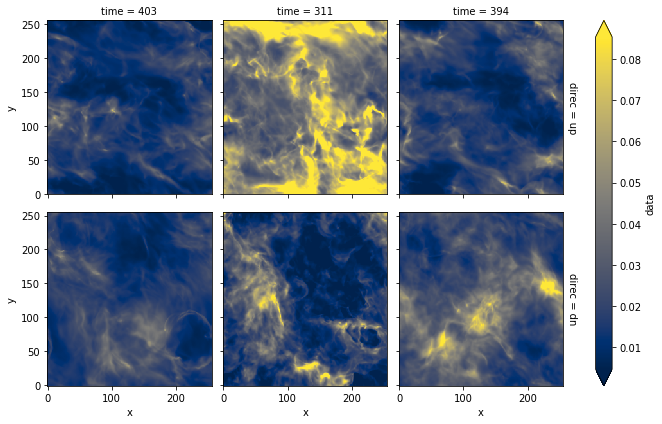

In [9]:
np.random.seed(1234)
facet_grid = data['data'].sel(time=np.random.randint(100, 500, 3), pol='t', direc=['up', 'dn'], zmin=300).plot(x='x', y='y', col='time', row='direc', cmap='cividis', robust=True)
facet_grid.fig.savefig(PLOT_DIR / 'up-vs-down-temperature.png')

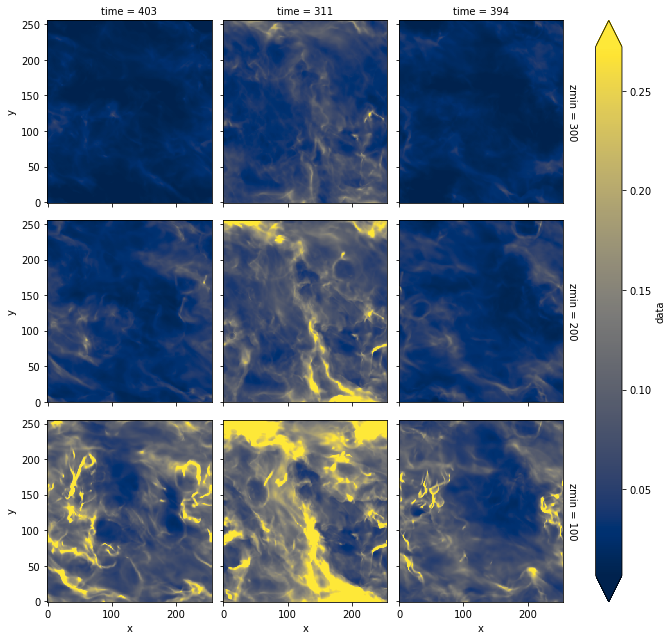

In [10]:
np.random.seed(1234)
facet_grid = data['data'].sel(time=np.random.randint(100, 500, 3), pol='t', direc='up', zmin=[300, 200, 100]).plot(x='x', y='y', col='time', row='zmin', cmap='cividis', robust=True)
facet_grid.fig.savefig(PLOT_DIR / 'zmin-300-100-temperature.png')

In [11]:
data['data'].sel(zmin=200, direc='up')

<xarray.DataArray 'data' (time: 575, pol: 3, x: 256, y: 256)>
array([[[[ 5.87721653e-02,  5.84978573e-02,  5.86950630e-02, ...,
           7.07496107e-02,  7.32180551e-02,  7.51641095e-02],
         [ 5.96407466e-02,  5.96774258e-02,  5.96048571e-02, ...,
           6.83880299e-02,  7.02629536e-02,  7.19935074e-02],
         [ 6.21577911e-02,  6.24250695e-02,  6.10443093e-02, ...,
           6.58940449e-02,  6.74245283e-02,  6.88558444e-02],
         ...,
         [ 5.98524585e-02,  5.87276556e-02,  5.86511455e-02, ...,
           6.82711750e-02,  7.43657723e-02,  7.89446309e-02],
         [ 5.95563129e-02,  5.82007654e-02,  5.83396964e-02, ...,
           7.00656325e-02,  7.53373355e-02,  7.91161358e-02],
         [ 5.91190197e-02,  5.81960045e-02,  5.83492965e-02, ...,
           7.10670725e-02,  7.50188529e-02,  7.78631717e-02]],

        [[ 2.17454857e-03,  1.70711172e-03,  1.34193129e-03, ...,
           1.69073301e-03,  1.71840587e-03,  1.77858782e-03],
         [ 2.00571236e-03,  1.81741861e-03,  1.25154725e-03, ...,
           1.53864746e-03,  1.40439707e-03,  1.19493878e-03],
         [ 2.05657515e-03,  1.99747295e-03,  1.80197682e-03, ...,
           1.26772036e-03,  1.20664551e-03,  8.86322174e-04],
         ...,
         [ 2.85760476e-03,  1.82936934e-03,  1.49530638e-03, ...,
           1.35430857e-03,  1.36604474e-03,  1.34970574e-03],
         [ 2.48418539e-03,  1.45589607e-03,  1.70620799e-03, ...,
           1.34933647e-03,  1.16807723e-03,  1.38840009e-03],
         [ 2.25610565e-03,  1.54960854e-03,  1.55800721e-03, ...,
           1.44227117e-03,  1.47651462e-03,  1.79050956e-03]],

        [[ 2.58531712e-04,  7.36356596e-04, -6.87501888e-05, ...,
           6.39769860e-05,  2.40008070e-04,  2.79633008e-04],
         [-6.10284260e-05,  5.29857294e-04,  2.34304593e-04, ...,
          -2.40688430e-04,  9.82648999e-07, -1.70031562e-05],
         [-3.74732772e-04,  4.02863603e-04,  1.01672974e-03, ...,
          -1.44720107e-04, -7.62013369e-05, -2.32144695e-04],
         ...,
         [ 1.25020114e-03,  1.06700673e-03,  1.02242746e-03, ...,
           5.71488927e-04,  5.59198088e-04,  7.81931682e-04],
         [ 8.88014329e-04,  1.29614060e-03,  7.06349208e-04, ...,
           4.80526825e-04,  6.58167701e-04,  1.07583846e-03],
         [ 4.79708600e-04,  1.04798353e-03,  2.34482490e-04, ...,
           3.76729149e-04,  6.39948819e-04,  8.62152199e-04]]],


       [[[ 5.09893522e-02,  5.47224693e-02,  5.53200282e-02, ...,
           6.73836246e-02,  6.59611970e-02,  6.76711202e-02],
         [ 5.24959676e-02,  5.99558204e-02,  6.42343834e-02, ...,
           7.13676885e-02,  6.91010877e-02,  6.97491542e-02],
         [ 5.65779954e-02,  6.73707351e-02,  7.92135373e-02, ...,
           7.48153776e-02,  7.62187541e-02,  7.64162391e-02],
         ...,
         [ 4.88220192e-02,  3.97073142e-02,  3.56143340e-02, ...,
           7.39062130e-02,  7.33288601e-02,  7.32767060e-02],
         [ 5.11510745e-02,  4.38894033e-02,  4.05737646e-02, ...,
           7.05895424e-02,  6.95508942e-02,  6.96291178e-02],
         [ 5.04164398e-02,  4.95669097e-02,  4.75122966e-02, ...,
           6.74628913e-02,  6.66723698e-02,  6.79254308e-02]],

        [[ 1.18148653e-03, -8.27714975e-05,  1.36273773e-03, ...,
           8.99306731e-04,  6.93612848e-04,  4.42183868e-04],
         [ 7.85626995e-04,  3.90301371e-04,  1.31787511e-03, ...,
           1.01950031e-03,  8.30102479e-04,  1.87922749e-04],
         [ 8.78829160e-04,  1.08199281e-04,  1.06837810e-03, ...,
           1.27934408e-03,  9.42748098e-04,  7.13951158e-05],
         ...,
         [ 4.84866672e-04,  4.84509394e-04,  5.52902115e-04, ...,
           1.20166806e-03,  1.29237690e-03,  1.03662268e-03],
         [ 5.64312795e-04,  3.18772043e-04,  6.96959440e-04, ...,
           1.09395152e-03,  8.68093804e-04,  6.74371608e-04],
         [ 2.06234181e-04,  5.56439336e-04,  9.54022515e-04, ...,
           9.50617134e-04,  6.79044053e-04,  5.92627039e-04]],

        [[-9.250

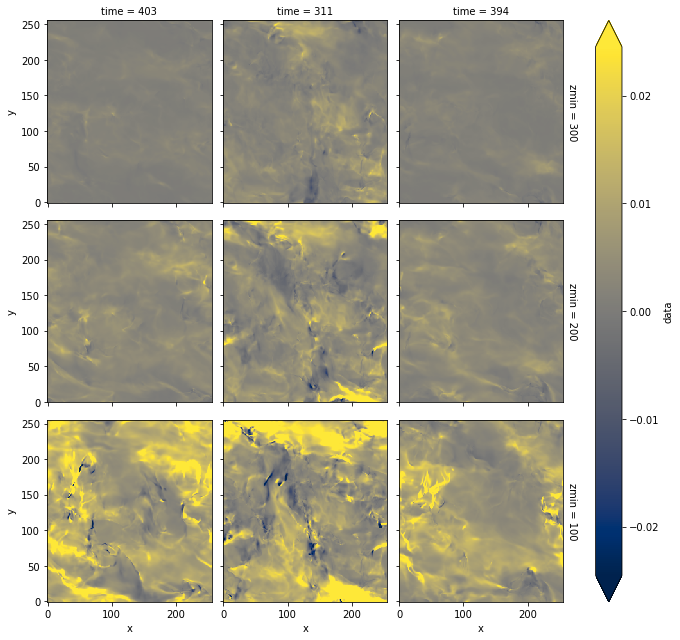

In [12]:
np.random.seed(1234)
facet_grid = data['data'].sel(time=np.random.randint(100, 500, 3), pol='q', direc='up', zmin=[300, 200, 100]).plot(x='x', y='y', col='time', row='zmin', cmap='cividis', robust=True)
facet_grid.fig.savefig(PLOT_DIR / 'zmin-300-100-stokesq.png')

# Pixel histograms

In [13]:
sample = data['data'].sel(time=np.random.randint(100, 500, 3), pol='t', direc='up', zmin=[300, 200, 100])

<xarray.DataArray 'histogram_data' (time: 3, zmin: 3, data_bin: 49)>
array([[[   0,    0,    0,    0,    0,  907, 1577, 1366, 2163, 2710,
         3342, 3755, 4015, 4185, 4126, 3486, 2764, 2498, 2412, 2372,
         2199, 2193, 1873, 1683, 1534, 1297, 1196, 1116, 1052, 1022,
          894,  803,  694,  660,  625,  489,  438,  431,  351,  288,
          274,  271,  267,  213,  182,  160,  128,  119,  116],
        [   0,    0,    0,    0,    0,   14,  158,  210,  239,  326,
          328,  421,  443,  516,  506,  729,  999, 1301, 1541, 1693,
         1782, 1921, 1967, 2105, 2025, 1968, 1953, 1910, 1986, 1815,
         1754, 1750, 1536, 1473, 1357, 1334, 1274, 1194, 1104,  994,
         1045,  945,  917,  909,  866,  775,  777,  743,  735],
        [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    1,   19,   46,  136,  233,  201,  232,  327,
          304,  332,  347,  307,  309,  326,  329,  333,  347,  378,
          463,  425,  437,  522,  539,  624,  789,  767,  749,  793,
          745,  779,  783,  831,  862,  751,  771,  728,  760]],

       [[   0,    0,    0,    0,    0,    0,    0,    0,    0,   23,
          149,  280,  410,  407,  830, 1278, 2013, 2461, 2578, 2569,
         2516, 2635, 2819, 2886, 2814, 3050, 3310, 3091, 2742, 2439,
         2250, 2145, 2075, 1845, 1740, 1725, 1628, 1406, 1133, 1021,
          855,  873,  788,  702,  625,  529,  490,  423,  327],
        [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,   24,   44,   97,  145,  161,  151,  155,  210,
          264,  280,  389,  570,  750,  898, 1024, 1177, 1496, 1490,
         1560, 1636, 1587, 1664, 1710, 1749, 1836, 1823, 1976, 2069,
         2070, 2185, 2091, 1957, 1889, 1687, 1603, 1635, 1541],
        [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,   21,   75,  200,  150,  221,  211,  256,  276,
          268,  271,  293,  399,  470,  589,  672,  728,  769,  882,
          826,  885,  859,  927,  845,  806,  799,  805,  789]],

       [[   0,    0,    0,    0,    0,    0,  236, 1248, 1859, 2676,
         3435, 3431, 3630, 3782, 3530, 3387, 3347, 3397, 2912, 2752,
         2803, 2738, 2612, 2223, 1904, 1563, 1474, 1261, 1076,  962,
          821,  723,  620,  595,  537,  480,  420,  376,  384,  315,
          279,  276,  233,  203,  160,  143,  109,   90,   89],
        [   0,    0,    0,    0,    0,    0,    0,    0,    0,   11,
          119,  432,  991, 1493, 2076, 2609, 2814, 2724, 2448, 2339,
         2456, 2412, 2627, 2653, 2605, 2407, 2176, 1895, 1963, 1851,
         1911, 1843, 1637, 1530, 1394, 1409, 1348, 1192, 1162, 1093,
          978,  932,  888,  788,  709,  673,  618,  540,  457],
        [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,   40,  159,  245,  362,  324,  493,  628,  799,
          787,  899, 1136, 1170, 1182, 1256, 1295, 1276, 1369, 1407,
         1576, 1540, 1564, 1622, 1700, 1555, 1618, 1639, 1622, 1583,
         1569, 1523, 1526, 1440, 1305, 1138, 1070,  994,  825]]])
Coordinates:
  * time      (time) int64 153 304 472
  * zmin      (zmin) int64 300 200 100
  * data_bin  (data_bin) float64 -0.008878 -0.006633 ... 0.09663 0.09888

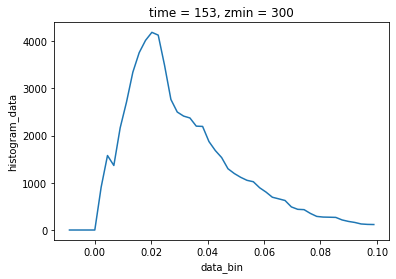

In [44]:
bins = np.linspace(-0.01, 0.1, 50)
h = histogram(sample, bins=[bins], dim=['x', 'y'])
display(h)
fig = h.isel(time=0, zmin=0).plot()

AttributeError: 'Line2D' object has no attribute 'fig'

# Power spectrum 

## Make mask with a few degree taper

In [36]:
mask = np.ones((256, 256))
ang = np.radians(np.sqrt(276.))
theta = 29.
ang = np.radians(theta)

In [37]:
nx, ny = 256, 256
apo_mask = make_square_mask(nx, ny, ang)
b = make_flat_bins(ang, nx, 8)

In [38]:
f0 = nmt.NmtFieldFlat(ang, ang, apo_mask, np.random.randn(1, 256, 256))
f2 = nmt.NmtFieldFlat(ang, ang, apo_mask, np.random.randn(2, 256, 256), purify_b=True, purify_e=True)

wsp00 = nmt.NmtWorkspaceFlat()
wsp00.compute_coupling_matrix(f0, f0, b)
wsp00.write_to("nmt_workspaces/wsp00_flat.fits")

wsp02 = nmt.NmtWorkspaceFlat()
wsp02.compute_coupling_matrix(f0, f2, b)
wsp02.write_to("nmt_workspaces/wsp02_flat.fits")

wsp22 = nmt.NmtWorkspaceFlat()
wsp22.compute_coupling_matrix(f2, f2, b)
wsp22.write_to("nmt_workspaces/wsp22_flat.fits")

In [39]:
spectra = apply_nmt_flat(data['data'], apo_mask, ang, b, wsp00=wsp00, wsp02=wsp02, wsp22=wsp22)
#log_spectra = np.log10(spectra)
#log_normed_spectra = apply_nmt_flat(log_normed_data, apo_mask, ang, b, wsp00=wsp00, wsp02=wsp02, wsp22=wsp22)

In [40]:
mean = spectra.mean(dim=['time'])
std = spectra.std(dim=['time'])
#log_mean = log_spectra.mean(dim=['time'], skipna=True)
#log_std = log_spectra.std(dim=['time'], skipna=True)

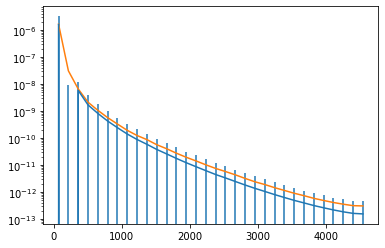

In [41]:
fig, ax = plt.subplots(1, 1)
sel = {
    'field': 'tt',
    'zmin': 300,
    'direc': 'dn',
}
ax.errorbar(mean.bandpowers, mean.sel(**sel), yerr=std.sel(**sel))
ax.plot(mean.bandpowers, std.sel(**sel))
ax.set_yscale('log')

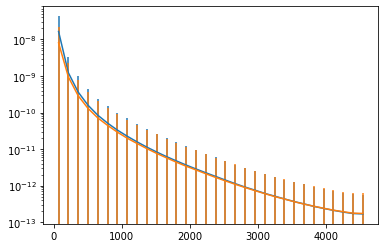

In [42]:
mean = spectra.mean(dim=['direc', 'zmin', 'time'])
std = spectra.std(dim=['direc', 'zmin', 'time'])

fig, ax = plt.subplots(1, 1)
ax.errorbar(mean.bandpowers, mean.sel(field='ee'), yerr=std.sel(field='ee'))
ax.errorbar(mean.bandpowers, mean.sel(field='bb'), yerr=std.sel(field='bb'))
ax.set_yscale('log')

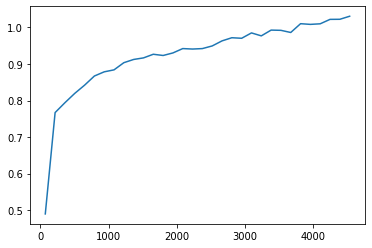

In [43]:
fig, ax = plt.subplots(1, 1)
ax.plot(mean.bandpowers, mean.sel(field='bb') / mean.sel(field='ee'))

In [ ]:
fig, ax = plt.subplots(1, 1)
sel = {
    'field': 'ee',
    'zmin': 100,
    'direc': 'dn',
}
ax.errorbar(log_mean.bandpowers, log_mean.sel(**sel), yerr=log_std.sel(**sel))

In [ ]:
fig, ax = plt.subplots(1, 1)
sel = {
    'field': 'tt',
    'zmin': 100,
    'direc': 'dn',
}
ax.errorbar(log_mean.bandpowers, log_mean.sel(**sel), yerr=log_std.sel(**sel))

In [ ]:
fig, ax = plt.subplots(1, 1)
sel = {
    'field': 'ee',
    'zmin': 100,
    'direc': 'dn',
}
ax.errorbar(log_mean.bandpowers, log_mean.sel(**sel), yerr=log_std.sel(**sel))

# Data Normalization

In [ ]:
normed

In [ ]:
normed_spectra = apply_nmt_flat(data['data'], mask, ang, b, wsp00=wsp00, wsp02=wsp02, wsp22=wsp22)

In [ ]:
log_normed_spectra = np.log10(normed_spectra)
log_normed_mean = log_normed_spectra.mean(dim=['time'], skipna=True)
log_normed_std = log_normed_spectra.std(dim=['time'], skipna=True)

In [ ]:
fig, ax = plt.subplots(1, 1)
sel = {
    'zmin': 100,
    'direc': 'dn',
}
ax.errorbar(log_normed_mean.bandpowers, log_normed_mean.sel(**sel, field='ee'), yerr=log_normed_std.sel(**sel, field='ee'))
ax.errorbar(log_normed_mean.bandpowers, log_normed_mean.sel(**sel, field='bb'), yerr=log_normed_std.sel(**sel, field='bb'))
#ax.errorbar(log_mean.bandpowers, log_mean.sel(**sel), yerr=log_std.sel(**sel))
ax.set_xscale('log')
ax.legend()

In [ ]:
fig, ax = plt.subplots(1, 1)
sel = {
    'zmin': 100,
    'direc': 'dn',
}

ax.errorbar(log_mean.bandpowers, log_mean.sel(**sel, field='ee'), yerr=log_std.sel(**sel, field='ee'), label='EE')
ax.errorbar(log_mean.bandpowers, log_mean.sel(**sel, field='bb'), yerr=log_std.sel(**sel, field='bb'), label='BB')

ax.set_xlabel(r"$\ell_b$")
ax.set_ylabel(r"$\log[C_\ell]$")

ax.set_xscale('log')
ax.legend()

# Polariaztion normalization

To normalize the negative values in the dataset, we first shift everything such that the minimum value is 1. Then we apply a log transformation, and standardization:

$$
y = {\rm std}(\log(R + {\rm min}(R) + 1))
$$

In [ ]:
pol = data['data'].sel(pol=['q', 'u'])

In [ ]:
pol = pol.stack(batch=['zmin', 'time', 'direc'])

In [ ]:
log_normed_pol = apply_per_image_standardization(np.log10(pol - pol.values.min() + 1))
normed_pol

In [ ]:
np.random.seed(1234)
facet_grid = pol.isel(batch=np.random.randint(0, 3000, 3), pol=0).plot(x='x', y='y', col='batch', cmap='cividis', robust=True)
facet_grid.fig.savefig(PLOT_DIR / 'zmin-300-100-pol.png')

In [ ]:
np.random.seed(1234)
facet_grid = log_normed_pol.isel(batch=np.random.randint(0, 3000, 3), pol=0).plot(x='x', y='y', col='batch', cmap='cividis', robust=True)
facet_grid.fig.savefig(PLOT_DIR / 'zmin-300-100-normed-pol.png')

In [ ]:
log_normed_spectra = apply_nmt_flat(log_normed_pol, apo_mask, ang, b, wsp22=wsp22)

In [ ]:
pol_spectra = apply_nmt_flat(pol, apo_mask, ang, b, wsp22=wsp22)

In [ ]:
mean = pol_spectra.mean(dim='batch', skipna=True)
std = pol_spectra.std(dim='batch', skipna=True)
fig, ax = plt.subplots(1, 1)
ax.errorbar(mean.bandpowers, mean.sel(field='ee'), yerr=std.sel(field='ee'))
ax.errorbar(mean.bandpowers, mean.sel(field='bb'), yerr=std.sel(field='bb'))
ax.set_yscale('log')
ax.set_xscale('log')

In [ ]:
mean = log_normed_spectra.mean(dim='batch', skipna=True)
std = log_normed_spectra.std(dim='batch', skipna=True)
fig, ax = plt.subplots(1, 1)
ax.errorbar(mean.bandpowers, mean.sel(field='ee'), yerr=std.sel(field='ee'))
ax.errorbar(mean.bandpowers, mean.sel(field='bb'), yerr=std.sel(field='bb'))
ax.set_yscale('log')
ax.set_xscale('log')

In [ ]:
fig, ax = plt.subplots(1, 1)
ax.plot(mean.bandpowers, mean.sel(field='bb') / mean.sel(field='ee'))
ax.set_xlim(300, 1000)
ax.set_ylim(0.7, 1.0)
ax.set_xlabel(r"$\ell$")
ax.set_ylabel(r"$BB / EE$")

# One point statistics

Calculate the histogram of the data.

In [ ]:
log_normed = apply_per_image_standardization(np.log10(data['data']))

In [ ]:
facet_grid = log_normed.sel(time=100, pol='t', direc='up', zmin=300).plot.hist(range=[-2.5, 2.5], bins=50)

In [ ]:
facet_grid = log_normed.sel(time=np.random.randint(100, 500, 3), pol='t', direc='up', zmin=[300, 200, 100]).plot(x='x', y='y', col='time', row='zmin', cmap='cividis', robust=True)

In [ ]:
facet_grid = normed.sel(time=np.random.randint(100, 500, 3), pol='t', direc='up', zmin=[300, 200, 100]).plot(x='x', y='y', col='time', row='zmin', cmap='cividis', robust=True)

# Write to file 

In [ ]:
spectra_dset = xa.Dataset(
    {
        'raw': log_spectra,
        'normed': log_normed_spectra,
    },
    coords=log_spectra.coords)

In [ ]:
spectra_dset.to_zarr("mhd_spectra.zarr", 'w')